# Install and Import Necessary Packages

In [1]:
# Install pandas_ta (technical indicators) and categorical encoders
!pip install pandas_ta
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e6e5764d9a90236234430d36f6ef0316a69df131b66679ace2ac3df862b780c1
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.7 MB/s eta 0:00:00


In [2]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pandas_ta
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
import category_encoders as ce
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import joblib

# Data Retrieval and Pre-Processing

In [3]:
# Obtain S&P500 stock tickers from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Use yf library to download data
end_date = '2024-08-02'
start_date = pd.to_datetime(end_date) - pd.DateOffset(3911)
df = yf.download(tickers = symbols_list, start = start_date, end = end_date).stack()

[**********************99%%**********************]  499 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%%**********************]  503 of 503 completed


In [4]:
# Group by ticker and count the number of entries for each stock
df.index.names = ['date', 'ticker']
ticker_counts = df.groupby('ticker').size()

# Display the count of entries for each stock
print("Number of entries per stock:")
print(ticker_counts)

# Check for any stocks with missing or additional entries
inconsistent_stocks = ticker_counts[ticker_counts != ticker_counts.median()]
print("\nStocks with inconsistent number of entries:")
print(inconsistent_stocks)

Number of entries per stock:
ticker
A       2693
AAL     2693
AAPL    2693
ABBV    2693
ABNB     915
        ... 
XYL     2693
YUM     2693
ZBH     2693
ZBRA    2693
ZTS     2693
Length: 503, dtype: int64

Stocks with inconsistent number of entries:
ticker
ABNB     915
ANET    2556
CARR    1100
CEG      637
CFG     2480
CRWD    1294
CTLT    2518
CTVA    1306
CZR     2482
DAY     1577
DOW     1352
ETSY    2340
FOX     1357
FOXA    1358
FTV     2033
GDDY    2351
GEHC     408
GEV       86
HLT     2676
HPE     2211
HWM     1949
INVH    1887
IR      1817
KEYS    2462
KHC     2285
KVUE     313
LW      1942
MRNA    1421
OTIS    1100
PAYC    2592
PYPL    2285
QRVO    2411
SOLV      86
SW        19
SYF     2518
UBER    1316
VICI    1656
VLTO     208
VST     1968
dtype: int64


In [5]:
# Reformat and drop certain stocks because of missing data (464 stocks left)
drop_index = ['ABNB', 'ANET', 'CARR', 'CEG', 'CFG', 'CRWD', 'CTLT', 'CTVA', 'CZR', 'DAY', 'DOW', 'ETSY', 'FOX',
              'FOXA', 'FTV', 'GDDY', 'GEHC', 'GEV', 'HLT', 'HPE', 'HWM', 'INVH', 'IR', 'KEYS', 'KHC', 'KVUE', 'LW', 'MRNA',
              'OTIS', 'PAYC', 'PYPL', 'QRVO', 'SOLV', 'SW', 'SYF', 'UBER', 'VICI', 'VLTO', 'VST']
df.columns = df.columns.str.lower()
for i in range(len(drop_index)):
  df = df.drop(index=drop_index[i], level='ticker')

# Feature Engineering

In [6]:
# Garman-Klass Volatility
df['gk_vol'] = ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)

# RSI
df['rsi'] = df.groupby(level='ticker')['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=14))

# ATR
def atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
  return atr
df['atr'] = df.groupby(level='ticker', group_keys=False).apply(atr)

# MACD
def macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
  return macd
df['macd'] = df.groupby(level='ticker', group_keys=False)['adj close'].apply(macd)

# EMA-10
df['ema10'] = df['adj close'].ewm(span=10, adjust=False).mean()

# EMA-50
df['ema50'] = df['adj close'].ewm(span=50, adjust=False).mean()

In [7]:
# Create labels for multi-class classification (1-4, where 1s have greatest downward movement and 4s have greatest upward movement for the next day)
num_stocks = df.index.get_level_values('ticker').nunique()
df['tmr_return'] = (df['adj close'] - df['open']) / df['open']
df['tmr_return'] = df['tmr_return'].shift(-num_stocks)

def classify_return(row, positive_threshold, negative_threshold):
    if row['tmr_return'] > 0:
        if row['tmr_return'] >= positive_threshold:
            return 3  # Upper 50% of positive returns
        else:
            return 2  # Lower 50% of positive returns
    else:
        if row['tmr_return'] <= negative_threshold:
            return 0  # Lower 50% of negative returns
        else:
            return 1  # Upper 50% of negative returns

positive_returns = df['tmr_return'][df['tmr_return'] > 0]
negative_returns = df['tmr_return'][df['tmr_return'] < 0]

positive_threshold = positive_returns.quantile(0.5)
negative_threshold = negative_returns.quantile(0.5)

df['label'] = df.apply(classify_return, args=(positive_threshold, negative_threshold), axis=1)

# Drop tmr_return column as we don't need it anymore
df = df.drop(['tmr_return'], axis = 1)

In [8]:
# We included 30 prior days to assist in calculations of RSI, ATR, MACD, and labels. Now we can remove them.
def remove_first_n_dates(df, n):
    unique_dates = df.index.get_level_values('date').unique()
    remaining_dates = unique_dates[n:]
    df_filtered = df.loc[df.index.get_level_values('date').isin(remaining_dates)]
    return df_filtered

df = remove_first_n_dates(df, 30)

In [9]:
# Now we need to handle missing data in RSI, ATR, MACD
imputer = IterativeImputer(max_iter=10, random_state=0)
df[['rsi', 'atr', 'macd']] = imputer.fit_transform(df[['rsi', 'atr', 'macd']])

In [10]:
# We need to drop the last day of the data because of the offset of the labels
df = df.iloc[:-num_stocks]

# Train/Test Split (Pre-PCA)

In [11]:
# Set 30 days of observations aside for testing
lookback_days = 30
test_df = df.groupby(level='ticker').tail(lookback_days + 1)
train_df = df.drop(test_df.index)

In [12]:
# Determine class imbalances in training set (we need to deal with this later)
train_df['label'].value_counts()

,count
label,
1,537743
0,536558
3,73612
2,72871


# Principal Component Analysis

In [ ]:
# Standardize the data (fit it to training data to avoid data leakage)
features_to_standardize = ['adj close', 'close', 'open', 'high', 'low', 'volume', 'gk_vol', 'rsi', 'atr', 'macd', 'ema10', 'ema50']
scaler = StandardScaler()
train_df[features_to_standardize] = scaler.fit_transform(train_df[features_to_standardize])
test_df[features_to_standardize] = scaler.transform(test_df[features_to_standardize])

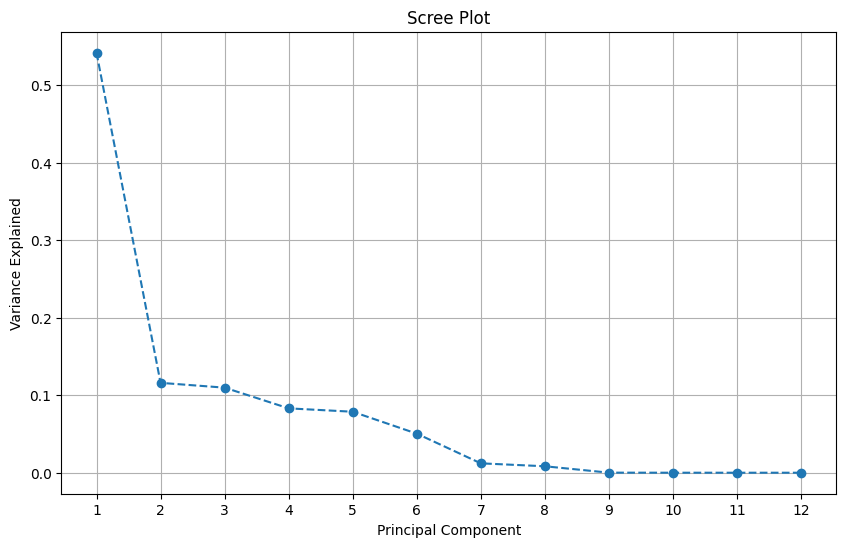

In [14]:
pca = PCA()

# PCA to find number of useful features
pca = PCA(n_components=len(features_to_standardize))
pca.fit(train_df[features_to_standardize])

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_

# Create a scree plot to see how many features to retain
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, len(explained_variance) + 1))
plt.grid()
plt.show()

In [15]:
# Perform Actual PCA (retain 7 features based on the scree plot)
pca = PCA(n_components=7)
pca.fit(train_df[features_to_standardize])

# Transform all data, but only using PCA fitted to training data
train_labels = train_df['label']
test_labels = test_df['label']
train_df = pd.DataFrame(pca.transform(train_df[features_to_standardize]), index=train_df.index, columns=[f'PC{i+1}' for i in range(7)])
test_df = pd.DataFrame(pca.transform(test_df[features_to_standardize]), index=test_df.index, columns=[f'PC{i+1}' for i in range(7)])

# Keep labels
train_df['label'] = train_labels
test_df['label'] = test_labels

# Data Transformation for LSTM Input

In [16]:
# Train/Validation Split
train_size = 0.8
unique_dates = train_df.index.get_level_values('date').unique()
split_index = int(len(unique_dates) * train_size)

train_dates = unique_dates[:split_index]
validation_dates = unique_dates[split_index:]

# Split the DataFrame
validation_df = train_df.loc[train_df.index.get_level_values('date').isin(validation_dates)]
train_df = train_df.loc[train_df.index.get_level_values('date').isin(train_dates)]

# Group each DataFrame by tickers
train_df = train_df.groupby('ticker').apply(lambda x: x.reset_index(drop=True))
validation_df = validation_df.groupby('ticker').apply(lambda x: x.reset_index(drop=True))
test_df = test_df.groupby('ticker').apply(lambda x: x.reset_index(drop=True))

In [17]:
# Split into X and y
X_train = train_df.drop('label', axis=1)
X_val = validation_df.drop('label', axis=1)
X_test = test_df.drop('label', axis=1)
y_train = train_df['label']
y_val = validation_df['label']
y_test = test_df['label']

In [18]:
# Binary-encode all tickers to fit dimensionality of LSTM input
X_train = X_train.reset_index()
X_val = X_val.reset_index()
X_test = X_test.reset_index()
binary_encoder = ce.BinaryEncoder(cols=['ticker'])
X_train = binary_encoder.fit_transform(X_train)
X_val = binary_encoder.transform(X_val)
X_test = binary_encoder.transform(X_test)

# Drop level_1 column
X_train = X_train.drop('level_1', axis=1)
X_val = X_val.drop('level_1', axis=1)
X_test = X_test.drop('level_1', axis=1)

In [19]:
# Convert DataFrame into 3D array for LSTM Input [num_samples, lookback_period, num_features]
# batch_size = 2074 (observation days in training - lookback period (30))
lookback_period = 30

def create_lstm_sequences_for_each_stock(X, y, lookback_period, num_stocks):
    X_sequences, y_sequences = [], []

    # Calculate the number of observations per stock
    num_observations_per_stock = len(X) // num_stocks

    # Iterate over each stock
    for i in range(num_stocks):
        # Calculate start and end indices for the current stock
        start_idx = i * num_observations_per_stock
        end_idx = (i + 1) * num_observations_per_stock

        # Extract data for the current stock
        X_stock = X[start_idx:end_idx]
        y_stock = y[start_idx:end_idx]

        # Generate sequences for the current stock
        sequence_length = len(X_stock) - lookback_period

        for j in range(sequence_length):
            # Extract the sequence of features
            sequence = X_stock[j:j + lookback_period]
            # Get the target value (e.g., next day's closing price)
            target = y_stock[j + lookback_period]

            X_sequences.append(sequence)
            y_sequences.append(target)

    return np.array(X_sequences), np.array(y_sequences)

# Create sequences for LSTM input
X_train, y_train = create_lstm_sequences_for_each_stock(X_train, y_train, lookback_period, num_stocks)
X_val, y_val = create_lstm_sequences_for_each_stock(X_val, y_val, lookback_period, num_stocks)
X_test, y_test = create_lstm_sequences_for_each_stock(X_test, y_test, lookback_period, num_stocks)

# Implementing RNN (LSTM)

In [26]:
# Build Model
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=150))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(units=4, activation='softmax'))

# Compile Model
optimizer = Adam()
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
# Rebalance classes using weights (manually calculate using the value counts from before)
class_weights = {
    0: 0.568,
    1: 0.567,
    2: 4.19,
    3: 4.14
}

In [28]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train stateless model on each stock by using a batch size equal to number of obs. per stock, do not shuffle
model.fit(X_train, y_train, epochs=30, batch_size=2074, shuffle = False, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight = class_weights)

Epoch 1/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.3617 - loss: 1.5268 - val_accuracy: 0.4490 - val_loss: 1.2171
Epoch 2/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.4619 - loss: 1.3300 - val_accuracy: 0.3328 - val_loss: 1.3316
Epoch 3/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5353 - loss: 1.2884 - val_accuracy: 0.6716 - val_loss: 1.0348
Epoch 4/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5696 - loss: 1.2675 - val_accuracy: 0.6559 - val_loss: 1.0586
Epoch 5/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5752 - loss: 1.2601 - val_accuracy: 0.6458 - val_loss: 1.0428
Epoch 6/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.5951 - loss: 1.2410 - val_accuracy: 0.6723 - val_loss: 1.0387
Epoch 7/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6153 - loss: 1.2183 - val_accuracy: 0.7300 - val_loss: 0.9957
Epoch 8/30
464/464 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6182 - loss: 1.2096 - 

In [29]:
# Model Evaluation (one day of testing not enough to generalize, but just to see sample performance)
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
results = model.evaluate(X_test, y_test)
print(results)
print(classification_report(y_test, y_pred))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5668 - loss: 1.0157 
[1.0245082378387451, 0.5754310488700867]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.65      0.85      0.74       307
           2       0.10      0.02      0.03        63
           3       0.11      0.07      0.08        92

    accuracy                           0.58       464
   macro avg       0.22      0.23      0.21       464
weighted avg       0.47      0.58      0.51       464



In [24]:
# Save scaler and pca for future prediction pre-processing
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

# Save LSTM
model.save('lstm.keras')